# Where will voters have the most political influence in 2020?

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display
import statsmodels.formula.api as smf
import statsmodels.api as sm
import altair as alt
from vega_datasets import data

In [4]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [5]:
all_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'output', 'voting_power.csv'))
all_df.head()

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
0,01,AL,president,2016,27.725147,-27.725147,0.418216,0.015084
1,02,AK,president,2016,14.730641,-14.730641,0.139405,0.009464
2,04,AZ,president,2016,3.545595,-3.545595,0.511152,0.144165
3,05,AR,president,2016,26.920978,-26.920978,0.278810,0.010357
4,06,CA,president,2016,30.109293,30.109293,2.555762,0.084883


In [6]:
all_df['office'].drop_duplicates()

0         president
51         ussenate
151         ushouse
582        governor
632     statesenate
2447     statehouse
Name: office, dtype: object

# Political Spending, Per Capita

Adding per capita spending for context. Might be worth adding into the index at some point, but I think that would just add complication and confusion for now. 

In [30]:
# Source, open secrets: https://www.opensecrets.org/overview/statetotals.php?cycle=2018
spend_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'misc', 'campaign_spend.csv'))
spend_df['dem_spend'] = (spend_df['dem_pct']/100)*spend_df['total_spend']
spend_df['rep_spend'] = (spend_df['rep_pct']/100)*spend_df['total_spend']
# Needs to be calculated on aggregated data below
#spend_df['spend_ratio'] = (spend_df['dem_pct']/100)/(spend_df['rep_pct']/100)

# Group by state and sum
spend_df = spend_df.groupby(by='state_name') \
   .agg({'total_spend': 'sum', 'dem_spend': 'sum', 'rep_spend': 'sum'})
spend_df.reset_index(drop=False, inplace=True)
spend_df['spend_ratio'] = spend_df['dem_spend']/spend_df['rep_spend']
spend_df.sort_values(by='total_spend', ascending=False).head()

# Join with state metadata and calculate per capita values
meta_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'misc', 'state_metadata.csv'))
capita_df = spend_df.merge(meta_df, on='state_name')
capita_df['capita_spend'] = capita_df['total_spend']/capita_df['pop_2018']
#capita_df['capita_overspend'] = (capita_df['rep_spend'] - capita_df['dem_spend'])/capita_df['pop_2018']
capita_df = capita_df.sort_values(by='capita_spend', ascending=False)
#capita_cols = [i for i in list(capita_df) if i not in ['pop_2018', 'electoral_votes_2016']]
capita_cols = ['state_name', 'state_abbr', 'fips', 'total_spend', 
    'dem_spend', 'rep_spend', 'spend_ratio', 'pop_2018', 'capita_spend']
capita_df = capita_df[capita_cols]
capita_df.reset_index(drop=True, inplace=True)

# What about capita_overspend?  (rep_spend - dem_spend) / people, then a positive number is where
# democrats should focus, negatives are where reps should focus to get up to even. So the assumption here
# is that if you are even in spending or overspending, marginal money does very little. Not sure if this is true.
# but the problem with this is that it divides the voting_power by a larger number the further from zero the 
# overspending is. That's not what you want, because the larger values lead to MORE marginal power. So you'd want to
# multiply this times the organizer_power, not divide it.
# This isn't really a great metric though because it mixes both state and federal numbers. Of course red state
# republicans will spend much more on state level elections than red state democrats. Just the nature of the beast,
# and it's not clear more spending will help democrats. So leave overspend out for now, but keep thinking about it.

# Output to CSV
# capita_out = os.path.join(os.getcwd(), 'data', 'output', 'capita_spend.csv')
# capita_df.to_csv(capita_out, index=False)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.io.formats.style.Styler.background_gradient.html#pandas.io.formats.style.Styler.background_gradient
# https://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-columns#43641446
table_cols = ['state_name','dem_spend', 'rep_spend', 'total_spend', 'spend_ratio', 'capita_spend']
#cmap = 'PuBu'
capita_df[capita_df.state_abbr != 'DC'][table_cols].style.background_gradient(cmap='Reds', low=0.0) 
#subset=['ratio', 'total_spend', 'capita_spend']

,state_name,dem_spend,rep_spend,total_spend,spend_ratio,capita_spend
1,Nevada,9.58895e+07,2.01594e+08,306905028,0.475657,101.142
2,Wyoming,1.21258e+07,2.73562e+07,40766386,0.443257,70.5622
3,New York,9.35142e+08,3.6063e+08,1343330895,2.59308,68.74
4,Virginia,2.12384e+08,3.01202e+08,527394144,0.705122,61.9175
5,Connecticut,1.08266e+08,7.01137e+07,183489472,1.54414,51.3593
6,Massachusetts,2.36511e+08,8.19427e+07,327728630,2.8863,47.4821
7,Illinois,3.18833e+08,2.62956e+08,592032450,1.2125,46.4664
8,California,1.12085e+09,5.2142e+08,1704809660,2.14961,43.0975
9,Maryland,1.87771e+08,6.00574e+07,256104458,3.12653,42.3823
10,Arkansas,3.66548e+07,6.50898e+07,103034559,0.563143,34.1873


In [8]:
r = capita_df['rep_spend'].sum()
d = capita_df['dem_spend'].sum()
print('Rep Total: ', r)
print('Dem Total: ', d)
print('D:R Ratio: ', d/r)

Rep Total:  5235297211.809999
Dem Total:  6055058826.71
D:R Ratio:  1.1565835867065482


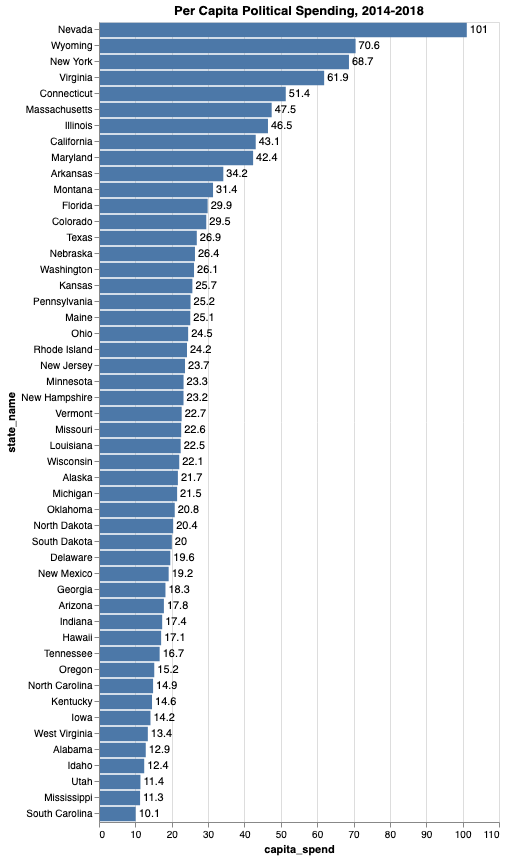

In [9]:
plot_df = capita_df.copy()

#Select out presidential margin to use in regression below
presmargin_df = all_df[all_df.office == 'president'].copy()
presmargin_df = presmargin_df[['state_abbr', 'dem_margin']]
presmargin_df['abs_margin'] = presmargin_df['dem_margin'].abs()
presmargin_df.sort_values(by='abs_margin', ascending=True)
presmargin_df.rename(columns={'abs_margin':'abs_presmargin'}, inplace=True)
presmargin_df = presmargin_df[['state_abbr', 'abs_presmargin']]
presmargin_df.sort_values(by='abs_presmargin', ascending=True).head()

plot_df = plot_df.merge(presmargin_df, on='state_abbr')
plot_df = plot_df[plot_df.state_name != 'District of Columbia']

bars = alt.Chart(plot_df,
    title='Per Capita Political Spending, 2014-2018'
).mark_bar().encode(
    x='capita_spend',
    y=alt.Y(
        'state_name:N',
        sort=alt.EncodingSortField(
            field="capita_spend",  # The field to use for the sort
            #op="sum",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in
            #order="ascending"  # The order to sort in
        )
    )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('capita_spend:Q', format=".3")
)

(bars + text).properties(background='#fff', height=800) #height=900

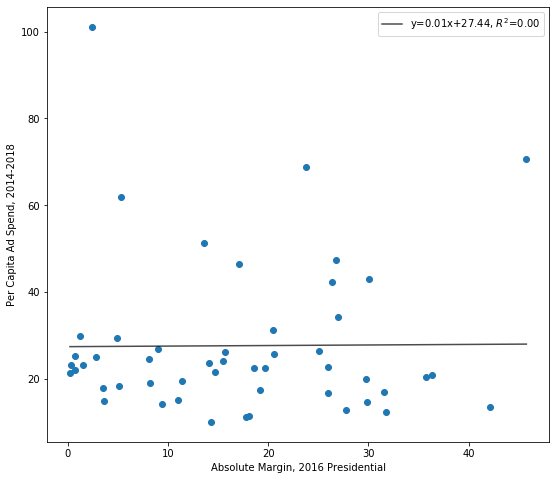

In [10]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(plot_df['abs_presmargin'], plot_df['capita_spend'])
#plt.scatter(plot_df['abs_presmargin'], plot_df['total_spend'])
ax.set_xlabel('Absolute Margin, 2016 Presidential')
ax.set_ylabel('Per Capita Ad Spend, 2014-2018')

x = pd.DataFrame({'abs_presmargin': np.linspace(plot_df['abs_presmargin'].min(),
    plot_df['abs_presmargin'].max(), 100)})

poly_1 = smf.ols(formula='capita_spend ~ 1 + abs_presmargin',
    data=plot_df, missing='drop').fit()
# poly_1 = smf.ols(formula='total_spend ~ 1 + abs_presmargin',
#     data=plot_df, missing='drop').fit()

plt.plot(x, poly_1.predict(x), 'k-',
    label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_1.rsquared,
    poly_1.params.abs_presmargin,
    poly_1.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()
#You'd expect a negative relationship, higher per capita spend on close margins.
#I think what's messing this up is state level elections, because a lot of money
#is spent in e.g. CA on state elections even if federal elections aren't close.

# 2016 Voting Power By Office

## US Senate

In [11]:
# Find the most recent election for each state having an election. 
# Double Georgia's entry

# https://en.wikipedia.org/wiki/2020_United_States_Senate_elections
sen_states = ['AL', 'AK', 'AZ', 'AR', 'CO', 'DE', 'GA', 'ID', 
    'IL', 'IA', 'KS', 'KE', 'LA', 'ME', 'MA', 'MI', 'MN', 'MS', 
    'MT', 'NE', 'NH', 'NJ', 'NM', 'NC', 'OK', 'OR', 'RI', 'SC', 
    'SD', 'TN', 'TX', 'VA', 'WV', 'WY']

sen_df = all_df[(all_df.office == 'ussenate') &
    (all_df.state_abbr.isin(sen_states))]

#sen_df = sen_df.groupby(by='state_abbr')['year'].nlargest(1)  #, 'year')
# Get most recent senate election: 
# https://stackoverflow.com/questions/40390634/pandas-groupby-nlargest-sum
sen_df = sen_df.groupby(by='state_abbr').apply(lambda g: g.nlargest(1, 'year'))
sen_df = sen_df.reset_index(drop=True)
#Duplicate GA
ga_df = sen_df[sen_df.state_abbr == 'GA']
ussenate_df = pd.concat([sen_df, ga_df]).reset_index(drop=True)
ussenate_df.head()

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
0,02,AK,ussenate,2016,15.195173,NaN,0.125,0.008226
1,01,AL,ussenate,2016,28.091532,-28.091532,0.125,0.004450
2,05,AR,ussenate,2016,23.600615,-23.600615,0.125,0.005296
3,04,AZ,ussenate,2018,2.344496,2.344496,0.125,0.053316
4,08,CO,ussenate,2016,5.664991,5.664991,0.125,0.022065


## US House, President

In [12]:
# All are re-elected, so just select power value for all from 2016/2018
ushouse_df = all_df[all_df.office == 'ushouse']
president_df = all_df[all_df.office == 'president']

In [13]:
president_df.head()

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
0,01,AL,president,2016,27.725147,-27.725147,0.418216,0.015084
1,02,AK,president,2016,14.730641,-14.730641,0.139405,0.009464
2,04,AZ,president,2016,3.545595,-3.545595,0.511152,0.144165
3,05,AR,president,2016,26.920978,-26.920978,0.278810,0.010357
4,06,CA,president,2016,30.109293,30.109293,2.555762,0.084883


In [14]:
ushouse_df.head()

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
151,4811,TX,ushouse,2018,61.699724,-61.699724,0.028736,0.000466
152,1602,ID,ushouse,2018,21.340436,-21.340436,0.028736,0.001347
153,3710,NC,ushouse,2018,18.585477,-18.585477,0.028736,0.001546
154,4004,OK,ushouse,2018,30.062374,-30.062374,0.028736,0.000956
155,3627,NY,ushouse,2018,4.788293,4.788293,0.028736,0.006001


## Governors

In [15]:
# Elections in these states in 2020:
# https://en.wikipedia.org/wiki/United_States_gubernatorial_elections,_2020
gov_states = ['DE', 'IN', 'MO', 'MT', 'NH', 'NC', 'ND', 'UT', 'VT', 'WA', 'WV']
gov_df = all_df[(all_df.office == 'governor') &
    (all_df.state_abbr.isin(gov_states))]

gov_df.head()

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
589,10,DE,governor,2016,19.152114,19.152114,0.073905,0.003859
595,18,IN,governor,2016,5.952019,-5.952019,0.511350,0.085912
606,29,MO,governor,2016,5.566694,-5.566694,0.468143,0.084097
607,30,MT,governor,2016,3.890765,3.890765,0.081174,0.020863
610,33,NH,governor,2018,7.044083,-7.044083,0.103652,0.014715


## State House

In [16]:
non_shstates = ['AL', 'LA', 'MD', 'MS', 'NE', 'NJ', 'VA']
sh_df = all_df[(all_df.office == 'statehouse') &
    (~all_df.state_abbr.isin(non_shstates))]
sh_df.sort_values(by='voting_power', ascending=False)

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
2993,12118,FL,statehouse,2016,0.084434,0.084434,0.006796,0.080490
6508,49032,UT,statehouse,2016,0.029279,-0.029279,0.001614,0.055118
6431,48105,TX,statehouse,2016,0.135089,-0.135089,0.007326,0.054234
5907,42156,PA,statehouse,2016,0.068476,0.068476,0.002416,0.035277
4666,32031,NV,statehouse,2016,0.120276,0.120276,0.002766,0.022999
...,...,...,...,...,...,...,...,...
4905,33207,NH,statehouse,2014,100.000000,100.000000,0.000130,0.000001
4911,33213,NH,statehouse,2014,100.000000,100.000000,0.000130,0.000001
4915,33301,NH,statehouse,2014,100.000000,-100.000000,0.000130,0.000001
4920,33306,NH,statehouse,2014,100.000000,100.000000,0.000130,0.000001


## State Senate

In [17]:
non_ssstates = ['AL', 'LA', 'MD', 'MI', 'MS', 'NJ', 'VA']
ss_df = all_df[(all_df.office == 'statesenate') &
    (~all_df.state_abbr.isin(non_ssstates))]
ss_df.sort_values(by='voting_power', ascending=False)

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
2018,55032,WI,statesenate,2016,0.070027,0.070027,0.006745,0.096324
1432,36008,NY,statesenate,2016,0.229391,0.229391,0.011877,0.051776
705,06029,CA,statesenate,2016,0.785628,0.785628,0.037865,0.048197
1407,33007,NH,statesenate,2016,0.061277,-0.061277,0.002164,0.035316
760,08020,CO,statesenate,2014,0.612572,0.612572,0.006231,0.010171
...,...,...,...,...,...,...,...,...
1555,38036,ND,statesenate,2016,100.000000,-100.000000,0.000619,0.000006
1556,38038,ND,statesenate,2016,100.000000,-100.000000,0.000619,0.000006
1566,38011,ND,statesenate,2014,100.000000,100.000000,0.000619,0.000006
1565,38009,ND,statesenate,2014,100.000000,100.000000,0.000619,0.000006


# Combined Races

In [18]:
combined_df = pd.concat([gov_df, ushouse_df, ussenate_df, president_df, sh_df, ss_df])
combined_df.sort_values(by='voting_power', ascending=False).head(10)

,geoid,state_abbr,office,year,abs_margin,dem_margin,power,voting_power
614,37,NC,governor,2016,0.218148,0.218148,0.793448,3.637197
22,26,MI,president,2016,0.223033,-0.223033,0.743494,3.333558
38,42,PA,president,2016,0.724270,-0.724270,0.929368,1.283180
9,12,FL,president,2016,1.198626,-1.198626,1.347584,1.124274
20,33,NH,ussenate,2016,0.137592,0.137592,0.125000,0.908481
49,55,WI,president,2016,0.764343,-0.764343,0.464684,0.607952
29,33,NH,president,2016,0.367596,0.367596,0.185874,0.505647
23,27,MN,president,2016,1.519841,1.519841,0.464684,0.305745
43,48,TX,president,2016,8.999428,-8.999428,1.765799,0.196212
467,1307,GA,ushouse,2018,0.149408,-0.149408,0.028736,0.192331


In [19]:
sum_df = combined_df.groupby(by='state_abbr') \
    .agg({'voting_power':'sum'}) \
    .reset_index(drop=False)

# Merge with capita_df data for context
sum_df = sum_df.merge(capita_df[['fips', 'state_abbr', 'capita_spend', 'spend_ratio']], on='state_abbr')
#sum_df['organizer_power_2020'] = (sum_df['voting_power']/sum_df['capita_spend'])*100
sum_df = sum_df[['fips', 'state_abbr', 'capita_spend','spend_ratio', 'voting_power']] #'capita_spend' #'organizer_power'
sum_df.rename(columns={'voting_power':'voting_power_2020'}, inplace=True)
# sum_df = sum_df.sort_values(by='voting_power_2020', ascending=False)
# sum_df.style.background_gradient(cmap='PuBu')
sum_df.head()

,fips,state_abbr,capita_spend,spend_ratio,voting_power_2020
0,2,AK,21.693003,0.792583,0.025444
1,1,AL,12.857250,0.327888,0.025742
2,5,AR,34.187306,0.563143,0.027550
3,4,AZ,17.844627,0.728903,0.241710
4,6,CA,43.097498,2.149612,0.392351


In [31]:
# This needs to be sum of values before non-2020 election were removed, from all_df
sumold_df = all_df.groupby(by='state_abbr') \
    .agg({'voting_power':'sum'}) \
    .reset_index(drop=False)

#sumold_df = sumold_df.sort_values(by='voting_power', ascending=False)
compare_df = sumold_df.merge(sum_df, on='state_abbr') #suffixes=('', '_2020')
compare_df['rank_change'] = compare_df['voting_power'].rank(ascending=False) - \
    compare_df['voting_power_2020'].rank(ascending=False)
compare_df = compare_df.sort_values(by='voting_power_2020', ascending=False)
compare_df.reset_index(drop=True, inplace=True)
compare_cols = ['state_abbr', 'capita_spend', 'spend_ratio', 'voting_power',
    'voting_power_2020', 'rank_change']

#cmap='PuBu' Reds
compare_df[compare_df.state_abbr != 'DC'][compare_cols].round(3).style.background_gradient(cmap='Reds', 
    subset=['voting_power', 'voting_power_2020', 'capita_spend', 'spend_ratio', 'rank_change'])


#So get rid of organizer_power in total, then just include per capita spend numbers/ratio and mention it
#as an indicator of the places that you might have more marginal effect (also mention you might try to 
#include in index in the future. Then include per capita
#spend graphic from other notebook, the scatter from other notebook, then this table color coded,
#and DataTables interactive.  Then also include the table below that breaks it down by office,
#showing NC is top because of all offices are close and running, which is the point of this analysis. 
#Then ride off into the sunset.
#Also include a map for good measure.

#So show the change here, then answer "Why the change?" with the table of state races below.
#The change is because NC has important elections at all levels, gov, state, fed senate, pres. 
#That's exactly the point of this analysis, consider all elections at once. 

#And also mention additional reasons NC will be important: redistricting in state and federal 
#house districts, right? That's a huge opportunity for gain on top of the already close races.


,state_abbr,capita_spend,spend_ratio,voting_power,voting_power_2020,rank_change
0,NC,14.873,0.744,4.105,4.025,1
1,MI,21.483,0.869,3.661,3.418,1
2,NH,23.242,1.349,1.524,1.485,2
3,PA,25.173,1.436,1.575,1.421,0
4,FL,29.879,0.707,6.552,1.394,-4
5,WI,22.068,0.677,1.193,0.738,0
6,TX,26.893,0.523,0.68,0.511,1
7,MN,23.256,1.052,0.514,0.464,2
8,GA,18.276,0.505,1.001,0.416,-2
9,CA,43.097,2.15,0.521,0.392,-1


In [32]:
statesum_df = sum_df.copy()
statesum_df.rename(columns={'voting_power_2020':'state_voting_power'}, inplace=True)
statesum_df = statesum_df[['state_abbr','state_voting_power']]
#top_states = statesum_df.sort_values(by='voting_power', ascending=False).head(10)['state_abbr']

stateoffice_df = combined_df.groupby(by=['state_abbr', 'office']) \
    .agg({'voting_power':'sum'}).copy()
stateoffice_df.reset_index(drop=False, inplace=True)
stateoffice_df = stateoffice_df.merge(statesum_df, on='state_abbr')
stateoffice_df.rename(columns={'voting_power': 'office_voting_power'}, inplace=True)
stateoffice_df.sort_values(by=['state_voting_power','office_voting_power'], ascending=False, inplace=True)
stateoffice_df = stateoffice_df[stateoffice_df.state_voting_power > 0.3].round(3)
stateoffice_df.reset_index(drop=False)
stateoffice_df.set_index(['state_abbr', 'state_voting_power', 'office'], inplace=True) #,'office'
#stateoffice_df = stateoffice_df.groupby(by=['state_abbr', 'state_voting_power', 'office']).agg({'voting_power':'max'})
stateoffice_df.style.background_gradient(cmap='Reds')

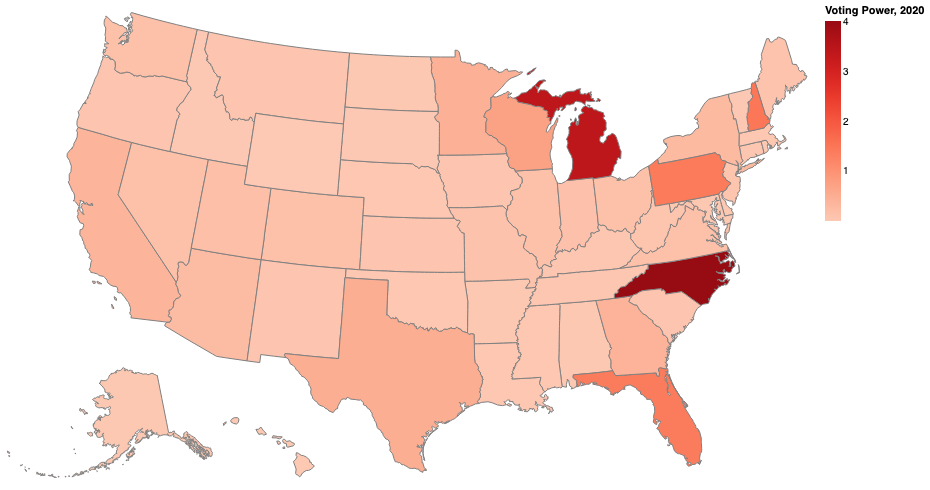

In [33]:
#https://altair-viz.github.io/gallery/choropleth_repeat.html
states = alt.topo_feature(data.us_10m.url, 'states') 
w = 800
h = (3/5)*w

data_df = sum_df.copy()
#data_df['voting_power_2020'] = np.log(data_df['voting_power_2020'])

mp = alt.Chart(states).mark_geoshape(
    stroke='gray',
    strokeWidth=1
).encode(
    alt.Color('voting_power_2020', type='quantitative',
        #plasma purpleblue lighttealblue lightgreyteal orangered oranges "viridis" plasma magma inferno
        scale=alt.Scale(scheme="Reds"),    #scheme="purpleblue" range=['#eaeaea','darkblue']
        legend=alt.Legend(title='Voting Power, 2020')
    )
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(data_df, 'fips', ['voting_power_2020']) 
).properties(
    width=w,
    height=h, 
    background='#fff'
).project(
    type='albersUsa'
).configure_view(strokeOpacity=0)

mp

In [23]:
# Slope plot showing rank change, overall --> 2020 rank.
# This graphic is just too hectic to be useful. Just stick with the ranks in table above. 

# plot_df = compare_df.copy()
# plot_df = pd.melt(plot_df, id_vars=['state_name'], value_vars=['voting_power_rank', 'voting_power_2020_rank'],
#     var_name='rank_type', value_name='rank')

# lines = alt.Chart(plot_df,
#     title='Change in Power Rank'
# ).mark_line().encode(
#     x=alt.X('rank_type:N', sort=alt.EncodingSortField(field='rank_type', order='ascending')),
#     y=alt.Y(
#         'rank:Q',
#         scale=alt.Scale(domain=[51,0]),
#         sort=alt.EncodingSortField(
#             field="power_rank",  # The field to use for the sort
#             #op="sum",  # The operation to run on the field prior to sorting
#             order="ascending"  # The order to sort in
#             #order="ascending"  # The order to sort in
#         )
#     ),
#     #detail='state_name:N'
#     color='state_name:N'
# ).properties(background='#fff', width=500, height=800)
# lines